In [1]:
import warnings
import scipy as sp
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
import scipy.io as sio
import seaborn as sns
import  math

imageSize = 250

primaryImage = np.load('subBeadPackPy250_justSpheres.npy')
secondaryImage = np.load('finalSimFile3D250.npy')

velSecondaryMat = sio.loadmat('velNormSecondary.mat')
velDataNormSecondary = velSecondaryMat['velNorm']

velPrimaryMat = sio.loadmat('velNormPrimary.mat')
velDataNormPrimary = velPrimaryMat['velNorm']

resolution = 16.81E-6 # adding resolution in meters

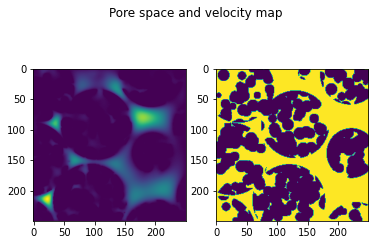

In [2]:
slice = 49

secondaryImage = np.transpose(secondaryImage)
primaryImage = np.transpose(primaryImage)

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormSecondary[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

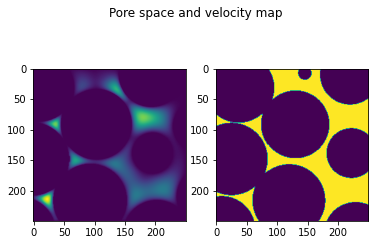

In [3]:
fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space and velocity map')
p1.imshow(velDataNormPrimary[:,:,slice])
p2.imshow(primaryImage[:,:,slice])



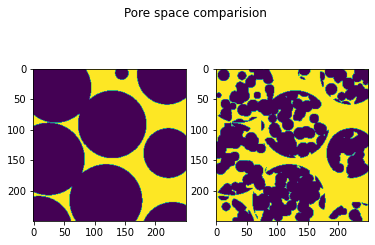

In [4]:
slice = 49

fig, (p1, p2) = plt.subplots(1, 2)

fig.suptitle('Pore space comparision')
p1.imshow(primaryImage[:,:,slice])
p2.imshow(secondaryImage[:,:,slice])

In [5]:
snowFiltSecondary = ps.filters.snow_partitioning(im=secondaryImage, return_all=True)
poreInfoSecondary = ps.networks.regions_to_network(snowFiltSecondary.regions, dt=snowFiltSecondary.dt)


------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  1436
Peaks after trimming saddle points:  938
Peaks after trimming nearby peaks:  922
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 922/922 [00:09<00:00, 97.21it/s] 


In [6]:
snowFiltPrimary = ps.filters.snow_partitioning(im=primaryImage, return_all=True)
poreInfoPrimary = ps.networks.regions_to_network(snowFiltPrimary.regions, dt=snowFiltPrimary.dt)




------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  113
Peaks after trimming saddle points:  104
Peaks after trimming nearby peaks:  93
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 93/93 [00:05<00:00, 17.94it/s]


In [7]:
cubeSize = len(secondaryImage)
velocitiesSecondary = {}
regionMapSecondary = snowFiltSecondary.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMapSecondary[a,b,c])
            if key != '0.0':
                if key in velocitiesSecondary:
                    velocitiesSecondary[key].append(velDataNormSecondary[a,b,c])
                else:
                    velocitiesSecondary.setdefault(key,[])
                    velocitiesSecondary[key].append(velDataNormSecondary[a,b,c])

In [18]:
nRegions = np.unique(snowFiltSecondary.regions).size
secondaryPoreDiamVecSecondary = np.zeros(nRegions,)
secondaryMedianVelNormPoreVec = np.zeros(nRegions,)

for a in range(0, poreInfoSecondary['pore.diameter'].size):
    secondaryPoreDiamVecSecondary[a] = poreInfoSecondary['pore.diameter'][a]
    secondaryMedianVelNormPoreVec[a] = np.median(velocitiesSecondary.get(str(a)))

In [11]:
cubeSize = len(primaryImage)
velocitiesPrimary= {}
regionMapPrimary = snowFiltPrimary.regions

for a in range(0, cubeSize):
    for b in range(0, cubeSize):
        for c in range(0, cubeSize):

            #print(beadPack[a,b,c])

            key = str(regionMapPrimary[a,b,c])
            if key != '0.0':
                if key in velocitiesPrimary:
                    velocitiesPrimary[key].append(velDataNormPrimary[a,b,c])
                else:
                    velocitiesPrimary.setdefault(key,[])
                    velocitiesPrimary[key].append(velDataNormPrimary[a,b,c])

In [19]:
nRegions = np.unique(snowFiltPrimary.regions).size
primaryPoreDiamVec = np.zeros(nRegions,)
primaryMedianVelNormPoreVec = np.zeros(nRegions,)

for a in range(0, poreInfoPrimary['pore.diameter'].size):
    primaryPoreDiamVec[a] = poreInfoPrimary['pore.diameter'][a]
    primaryMedianVelNormPoreVec[a] = np.median(velocitiesPrimary.get(str(a)))

In [16]:
# Bin pore diameter data
#max(poreInfo['pore.diameter'])
#min(poreInfo['pore.diameter'])
n_bins = 100

primaryPoreBins = np.linspace(0.1,60,n_bins)
primaryPoreDiamVec = poreInfoPrimary['pore.diameter']
primaryBinnedInd = np.digitize(primaryPoreDiamVec, primaryPoreBins)

allKeys = np.round(primaryPoreBins,2)
primaryBinnedPoreDiam = dict.fromkeys(allKeys)

for i in primaryBinnedPoreDiam.keys():
    primaryBinnedPoreDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(primaryBinnedInd)):
    key=primaryPoreBins[primaryBinnedInd[i]]
    key = round(key,2)
    primaryBinnedPoreDiam[key].append(primaryPoreDiamVec[i])
    #binnedPoreDiam[key].append(poreDispVector[i])

#regionLabel[i].append
secondaryPoreBins = np.linspace(0.1,60,n_bins)
secondaryPoreDiamVec = poreInfoSecondary['pore.diameter']
secondaryBinnedInd = np.digitize(secondaryPoreDiamVec, secondaryPoreBins)

allKeys = np.round(secondaryPoreBins,2)
secondaryBinnedPoreDiam = dict.fromkeys(allKeys)

for i in secondaryBinnedPoreDiam.keys():
    secondaryBinnedPoreDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(secondaryBinnedInd)):
    key=secondaryPoreBins[secondaryBinnedInd[i]]
    key = round(key,2)
    secondaryBinnedPoreDiam[key].append(secondaryPoreDiamVec[i])
    #binnedPoreDiam[key].append(poreDispVector[i])
#regionLabel[i].append

In [44]:
####################################################
# Bin Velocity data
nVelBins = 100
velBins = np.logspace(-9,-4,nVelBins+1)
binnedInd = np.digitize(primaryMedianVelNormPoreVec, velBins)

allKeys = velBins
primaryBinnedPoreVelNorm = dict.fromkeys(allKeys)

for i in primaryBinnedPoreVelNorm.keys():
    primaryBinnedPoreVelNorm[i] = []

 # currently storing all of the velocities in a pore of a given diameter
for i in range(0, len(binnedInd)):
    if binnedInd[i] == 100:
        key = velBins[99]
    else:
        key=velBins[binnedInd[i]]
    primaryBinnedPoreVelNorm[key].append(primaryMedianVelNormPoreVec[i])



velBins = np.logspace(-9,-4,nVelBins)
binnedInd = np.digitize(secondaryMedianVelNormPoreVec, velBins)
allKeys = velBins
secondaryBinnedPoreVelNorm = dict.fromkeys(allKeys)

for i in secondaryBinnedPoreVelNorm.keys():
    secondaryBinnedPoreVelNorm[i] = []

 # currently storing all of the velocities in a pore of a given diameter
for i in range(0, len(binnedInd)):
    if binnedInd[i] == 100:
        key = velBins[99]
    else:
        key=velBins[binnedInd[i]]
    secondaryBinnedPoreVelNorm[key].append(secondaryMedianVelNormPoreVec[i])

In [59]:
poreBins = np.linspace(0.1,60,n_bins)
primaryPoreDiamVec = poreInfoPrimary['pore.diameter']
binnedInd = np.digitize(primaryPoreDiamVec, poreBins)
velBins = np.logspace(-9,-4,nVelBins+1)

allKeys = np.round(poreBins,2)
primaryBinnedPoreDispAtDiam = dict.fromkeys(allKeys)

for i in primaryBinnedPoreDispAtDiam.keys():
    primaryBinnedPoreDispAtDiam[i] = []

# currently storing all of the diameters of a pore for a binned pore size
for i in range(1, len(binnedInd)):
    key = poreBins[binnedInd[i]]
    key = round(key,2)
    value = primaryPoreDiamVec[i]
    primaryBinnedPoreDispAtDiam[key].append(value)
#regionLabel[i].append

primaryImageMap = np.zeros([n_bins, nVelBins])
keyList = list(primaryBinnedPoreDispAtDiam.keys())
for i in range(1,len(keyList)):
    key=keyList[i]
    temp = np.histogram(primaryBinnedPoreDispAtDiam[key],velBins,density='True')
    temp2 = temp[0][:]
    temp2[:] = [0 if math.isnan(ele) else ele for ele in temp2]
    primaryImageMap[i,:] =  temp2


<ipython-input-60-a8ad8b231bd0>:20: UserWarning: No contour levels were found within the data range.
  ax2.contour(poreBins,velBins,filtMap,levels)


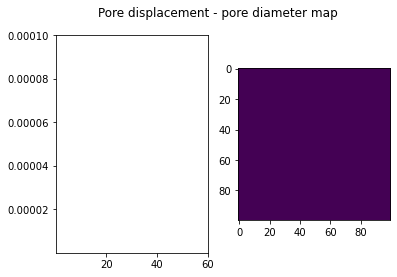

In [60]:
poreBins = np.linspace(0.1,60,n_bins)
velBins = np.logspace(-9,-4,nVelBins)

filtMap = sp.ndimage.gaussian_filter(primaryImageMap, 6)
levels = np.linspace(filtMap.min(),filtMap.max(),100)
#levels = np.flipud(levels)
# This should be an intensity plot of pore diameter and displacement
fig2 = plt.figure()
plt.suptitle('Pore displacement - pore diameter map')

ax1 = fig2.add_subplot(1,2,2)
filtMapFlip = np.flipud(filtMap)
ax1.imshow(filtMapFlip)

#xi = np.linspace(-2.1,2.1,100)
#yi = np.linspace(-2.1,2.1,100)
#zi = sp.interpolate.griddata((velBins, poreBins), filtMap, (xi[None,:], yi[:,None]), method='cubic')

ax2 = fig2.add_subplot(1,2,1)
ax2.contour(poreBins,velBins,filtMap,levels)
#plt.contourf(xi,yi,zi)


